In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import MaxNLocator
import ast

# Feature Importance (All_Cleaned)

In [12]:
def data_from_files_FI(relative_path):
    file_list_results = glob.glob(relative_path)
    features_sum = np.zeros((211,1))
    if 'lagged' in relative_path.lower():
        features_sum = np.zeros((275,1))

    for file in file_list_results:
        features_df = pd.read_csv(file)
        features_sum += features_df.values
    return features_sum / np.sum(features_sum) * 100 # Procent

In [13]:
def find_max_FI(features_importances, dataset_name):
    max_indices = np.argpartition(features_importances, -10, axis=0)[-10:]
    data = pd.read_csv(f'Data/{dataset_name}_data.csv') # Use same data to get right columns
    data = data.iloc[:,2:]
    print(f'Data features: {data.shape[1]}')
    print(f'Features from files: {features_importances.shape[0]}')
    max_features = data.columns.values[max_indices.flatten()]
    max_values = features_importances[max_indices.flatten()].flatten() 
    return max_features, max_values

In [14]:
def feature_importance_plot(feature_values, feature_names, dataset_name, model_name):
    x_values = np.arange(len(feature_values))
    plt.barh(x_values, feature_values)
    plt.yticks(x_values, feature_names, rotation=0, ha='right')
    plt.xlabel('Importances (%)')
    plt.title(f'Total Feature Importances for {model_name} on {dataset_name} data')
    plt.grid()
    plt.show()

In [15]:
def all_FI(dataset_name, model_names):
    for model_name in model_names:
        FI = data_from_files_FI(f'Results/Separate_Runs/{dataset_name}/{model_name}/*feature_importances365.csv')
        print(f'Check sum = 100%: {int(np.sum(FI))==100}')
        max_features, max_values = find_max_FI(FI, dataset_name)
        feature_importance_plot(max_values, max_features, dataset_name, model_name) 

Check sum = 100%: True
Data features: 275
Features from files: 275


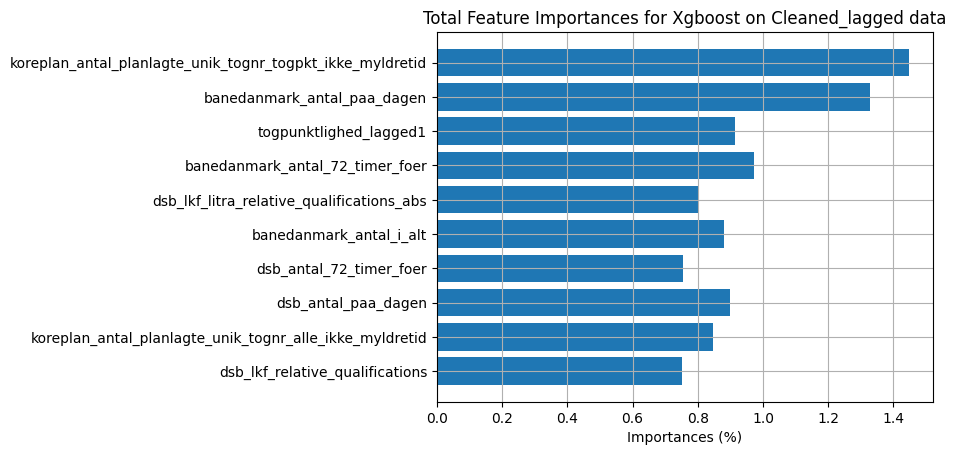

Check sum = 100%: True
Data features: 275
Features from files: 275


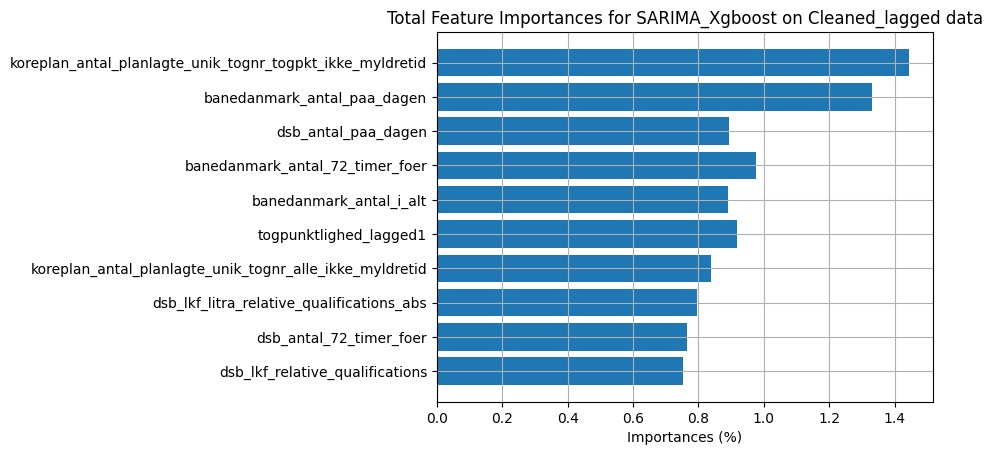

Check sum = 100%: True
Data features: 275
Features from files: 275


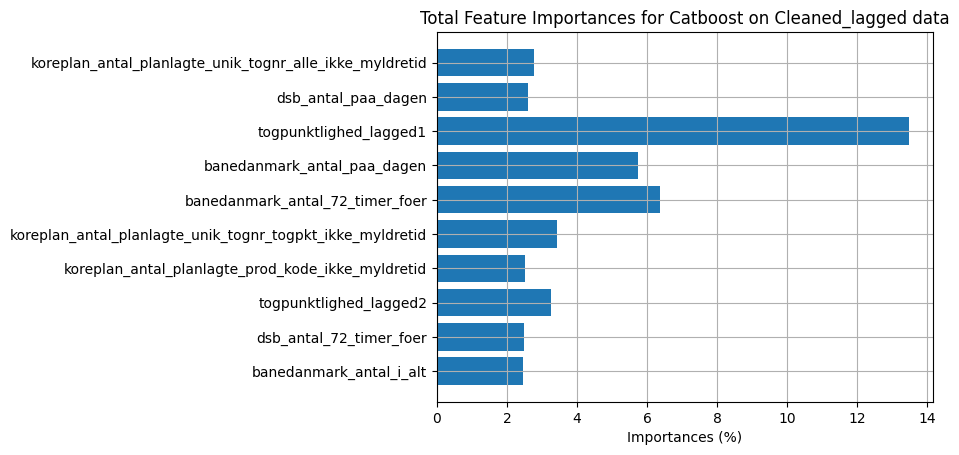

Check sum = 100%: False
Data features: 275
Features from files: 275


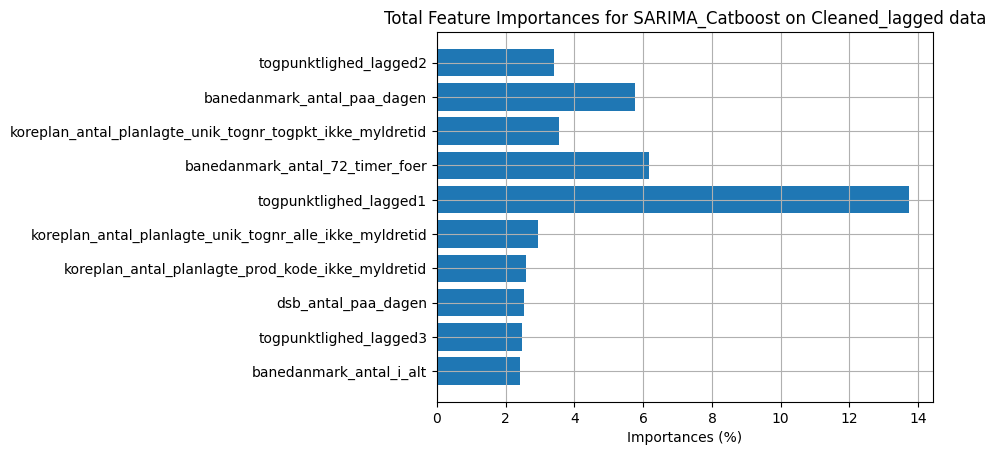

In [16]:
#all_FI('Cleaned', ['Xgboost', 'SARIMA_Xgboost', 'Catboost','SARIMA_Catboost'])
all_FI('Cleaned_lagged', ['Xgboost', 'SARIMA_Xgboost', 'Catboost','SARIMA_Catboost'])
# Not interesting to see together.

# Error (All on Cleaned.csv)

In [38]:
def data_from_files_error(relative_path):
    file_list_results = glob.glob(relative_path)
    
    strækning_station = []
    errors_baseline = []
    errors_arima = []
    errors_full = []

    for file in file_list_results:
        index_start = len(relative_path.split('*')[0])
        strækning_station += [file[index_start:].split('_')[0]]
        results_df = pd.read_csv(file)
        errors_baseline += [results_df['Error_baseline'][0]]
        errors_arima += [results_df.get('Error_arima', [None])[0]] # No ARIMA column in only Boosted
        errors_full += [results_df['Error_full'][0]]
    
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_arima, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_arima', 'Errors_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_full'])

In [39]:
def extract_train_routes(specific_train_route, errors_df):
    return errors_df[errors_df['route_station'].str.startswith(f'({specific_train_route},')]

In [40]:
def error_plot(df):
    df = df.sort_values(by='route_station')

    bar_width = 0.25
    index = range(len(df))
    # Plot baseline errors
    plt.bar(index, df['Errors_baseline'], bar_width, label='Baseline')
    # Plot ARIMA errors if available
    displacement = 1
    if 'Errors_arima' in df.columns:
        plt.bar([i + bar_width for i in index], df['Errors_arima'], bar_width, label='ARIMA')
        displacement = 2
    # Plot full errors
    plt.bar([i + displacement*bar_width for i in index], df['Errors_full'], bar_width, label='Full')

    plt.xlabel('(Strækning, Station)')
    plt.ylabel('Error')
    plt.title('Error comparison for (Strækning, Station) pairs')

    if displacement == 1:
        plt.xticks([i + bar_width/2 for i in index], df['route_station'])
    else: plt.xticks([i + bar_width for i in index], df['route_station'])

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [41]:
def error_function(dataset_name, model_name, specific_train_route=0, use_mean=False):
    errors_df = data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')
    if use_mean:
        mean_errors = pd.DataFrame(errors_df.mean(axis=0, numeric_only=True)).T
        mean_errors = mean_errors.assign(route_station='Mean')
        error_plot(mean_errors)
    else:
        errors_specific_route = extract_train_routes(specific_train_route, errors_df)
        error_plot(errors_specific_route)

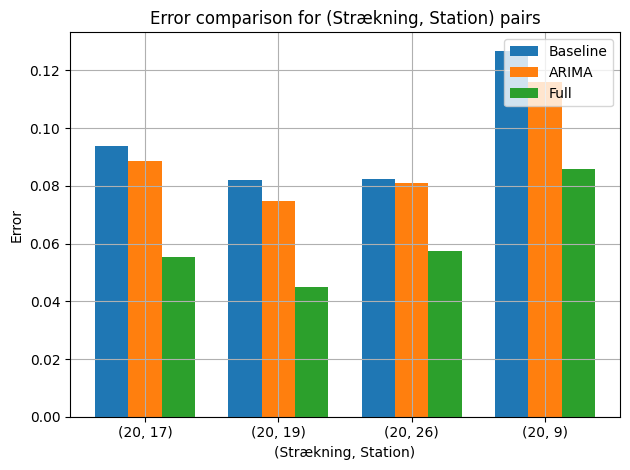

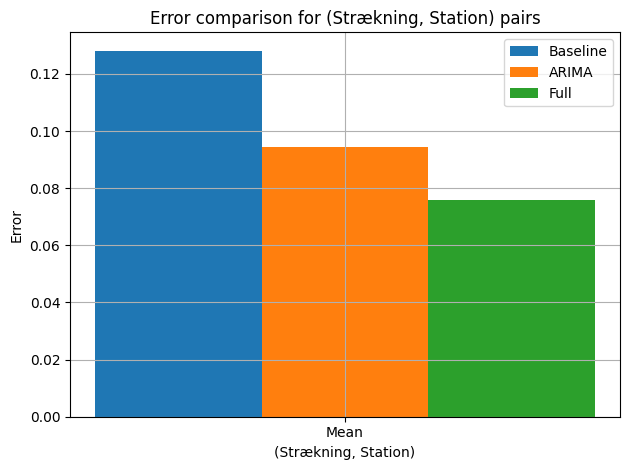

In [42]:
error_function('Cleaned', 'SARIMA_Xgboost', 20)

error_function('Cleaned', 'SARIMA_Xgboost', use_mean=True)

In [43]:
def data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean):
    data = []
    for model_name in model_names:
        dataset =  data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')
        if use_mean:
            data += [pd.DataFrame(dataset.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')]
        else:
            data += [extract_train_routes(specific_train_route, dataset)]
    return data

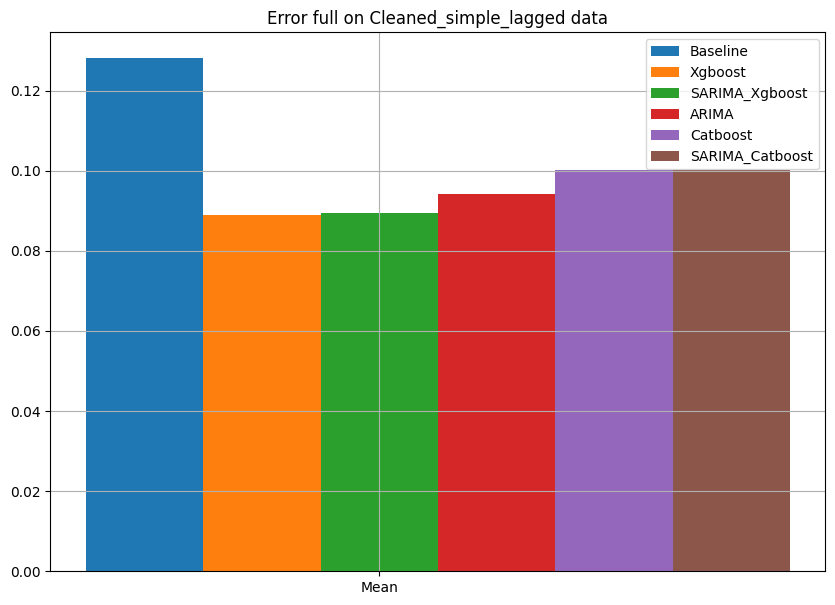

In [44]:
# Plot same columns across models/datasets

def plot_columns(model_names, dataset_name, specific_train_route, column, column_arima=None, use_mean=False):
    datasets = data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean)
    plt.figure(figsize=(10,7))
    bar_width = 0.15
    index = range(len(datasets[0]))
    arima_found=False
    plt.bar([j + bar_width for j in index], datasets[0]['Errors_baseline'], bar_width, label='Baseline')
    counter = 0
    for i, (name, dataset) in enumerate(zip(model_names, datasets)):
        dataset = dataset.sort_values(by='route_station')
        plt.bar([j + (counter+2) * bar_width for j in index], dataset[column].values, bar_width, label=name)
        counter += 1
        if column_arima in dataset.columns and not arima_found:
            plt.bar([j + (counter+2) * bar_width for j in index], dataset[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([i + 3 * bar_width for i in index], datasets[0]['route_station'])
        #print(dataset)
    
    plt.legend()
    plt.title(f'Error full on {dataset_name} data')
    plt.grid()

plot_columns(['Xgboost', 'SARIMA_Xgboost', 'Catboost', 'SARIMA_Catboost'], 'Cleaned_simple_lagged', 20, 'Errors_full', column_arima='Errors_arima', use_mean=True)

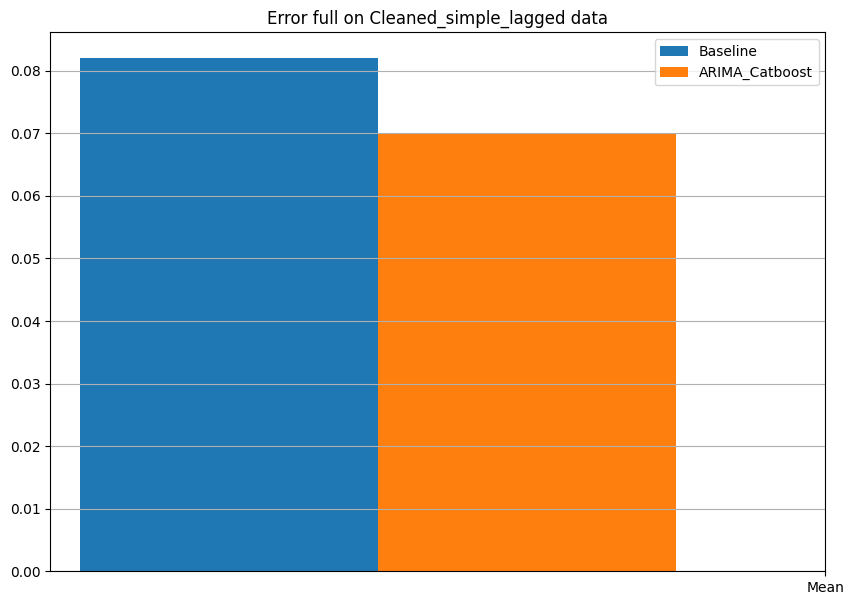

In [45]:
# Plot same columns across models/datasets
def data_from_files_error(relative_path):
    file_list_results = glob.glob(relative_path)
    
    strækning_station = []
    errors_baseline = []
    errors_arima = []
    errors_full = []

    for file in file_list_results:
        index_start = len(relative_path.split('*')[0])
        strækning_station += [file[index_start:].split('_')[0]]
        results_df = pd.read_csv(file)
        errors_baseline += [results_df['Error_baseline0'][0]]
        errors_arima += [results_df.get('Error_ARIMA0', [None])[0]] # No ARIMA column in only Boosted
        errors_full += [results_df['Error_full0'][0]]
    
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_arima, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_arima', 'Errors_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, errors_baseline, errors_full)), columns=['route_station', 'Errors_baseline', 'Errors_full'])

def data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean):
    data = []
    for model_name in model_names:
        dataset =  data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')
        if use_mean:
            data += [pd.DataFrame(dataset.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')]
        else:
            data += [extract_train_routes(specific_train_route, dataset)]
    return data

def plot_columns(model_names, dataset_name, specific_train_route, column, column_arima=None, use_mean=False):
    datasets = data_from_all_models_in_dataset(dataset_name, model_names, specific_train_route, use_mean)
    plt.figure(figsize=(10,7))
    bar_width = 0.15
    index = range(len(datasets[0]))
    arima_found=False
    plt.bar([j + bar_width for j in index], datasets[0]['Errors_baseline'], bar_width, label='Baseline')
    counter = 0
    for i, (name, dataset) in enumerate(zip(model_names, datasets)):
        dataset = dataset.sort_values(by='route_station')
        plt.bar([j + (counter+2) * bar_width for j in index], dataset[column].values, bar_width, label=name)
        counter += 1
        if column_arima in dataset.columns and not arima_found:
            plt.bar([j + (counter+2) * bar_width for j in index], dataset[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([i + 3 * bar_width for i in index], datasets[0]['route_station'])
        #print(dataset)
    
    plt.legend()
    plt.title(f'Error full on {dataset_name} data')
    plt.grid()

plot_columns(['ARIMA_Catboost'], 'Cleaned_simple_lagged', 20, 'Errors_full', column_arima='Errors_ARIMA0', use_mean=True)

In [49]:
results_df_x = pd.read_csv(f'Results/Separate_Runs/Cleaned_simple_lagged/ARIMA_Catboost/(20, 19)_Boosted1_results365.csv')
results_df = pd.read_csv('Results/Separate_Runs/Cleaned_simple_lagged/SARIMA_Catboost/(20, 19)_SARIMA_Catboost1_results365.csv')

<BarContainer object of 365 artists>

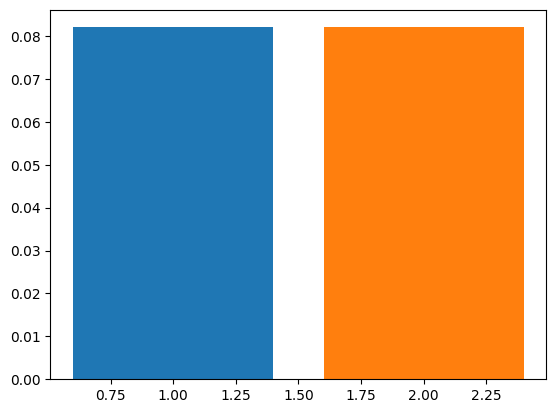

In [55]:
plt.bar(1, results_df['Error_baseline'])
plt.bar(2, results_df_x['Error_baseline0'])

In [52]:
results_df['Error_baseline']

0      0.082032
1      0.082032
2      0.082032
3      0.082032
4      0.082032
         ...   
360    0.082032
361    0.082032
362    0.082032
363    0.082032
364    0.082032
Name: Error_baseline, Length: 365, dtype: float64

# CV scores

In [24]:
def data_from_files_CV(relative_path):
    file_list_results = glob.glob(relative_path)
    index_start = len(relative_path.split('*')[0])

    strækning_station =[]
    cv_full = []
    cv_arima = []
    cv_baseline = []

    for file in file_list_results:
        results_df = pd.read_csv(file)
        strækning_station += [file[index_start:].split('_')[0]]
        cv_full += [results_df['CV_score_full']]
        cv_arima += [results_df.get('CV_score_arima', [None])]
        cv_baseline += [results_df['CV_score_baseline']]
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, cv_baseline, cv_arima, cv_full)), columns=['route_station', 'CV_baseline', 'CV_arima', 'CV_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, cv_baseline, cv_full)), columns=['route_station', 'CV_baseline', 'CV_full'])

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def hist_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    max_score = max(max(cv_scores_baseline), max(cv_scores_full))
    min_score = min(min(cv_scores_baseline), min(cv_scores_full))
    
    arima_check = not cv_scores_arima.empty

    if arima_check:
        max_score = max(max_score, max(cv_scores_arima))
        min_score = min(min_score, min(cv_scores_arima))
    
    num_bins = 15
    bins = np.linspace(min_score, max_score, num_bins)
    
    plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.5, label='Baseline')
    
    if arima_check:
        plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.5, label='ARIMA')
    
    plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.5, label='Full')

    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('MAE')
    plt.ylabel('Occurrences')
    plt.legend(loc='upper right')
    plt.grid()
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
    plt.show()

def linechart_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    plt.plot(cv_scores_baseline, label='Baseline')
    
    if not cv_scores_arima.empty:
        plt.plot(cv_scores_arima, label='ARIMA')

    plt.plot(cv_scores_full, label='Full')
    
    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('Data points')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

def plot_cv_scores(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima=None):
    hist_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima)
    linechart_plot(strækning_station, cv_scores_full, cv_scores_baseline, cv_scores_arima)

In [78]:
def cv_function(dataset_name, model_name, specific_train_route):
    cv_scores = data_from_files_CV(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')#['Errors_baseline'][0]
    cv_scores_specific_route = extract_train_routes(specific_train_route, cv_scores)
    for _, row in cv_scores_specific_route.iterrows():
        plot_cv_scores(row['route_station'], row['CV_full'], row['CV_baseline'], cv_scores_arima=row.get('CV_arima', pd.DataFrame()))

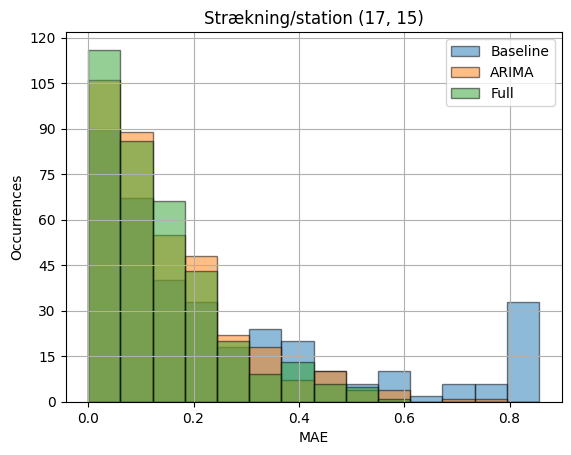

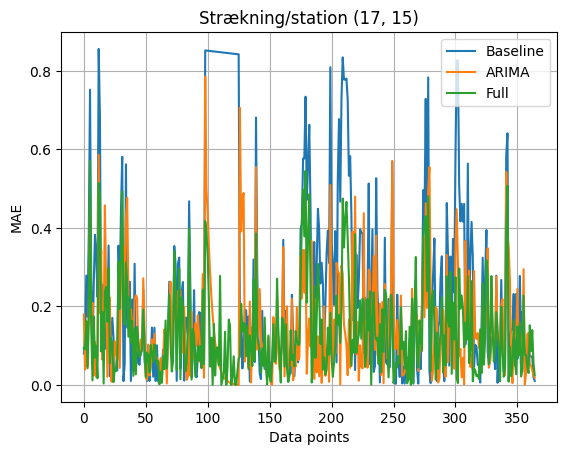

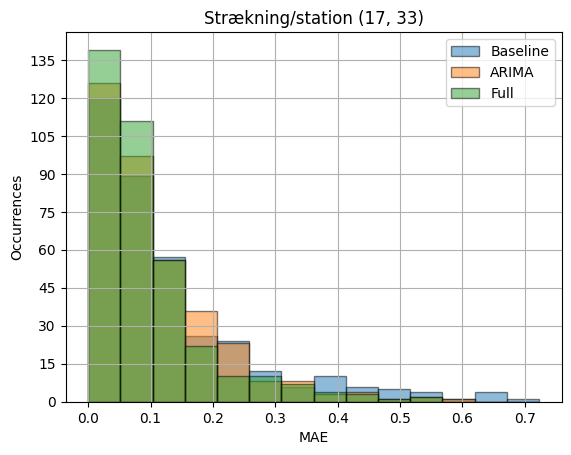

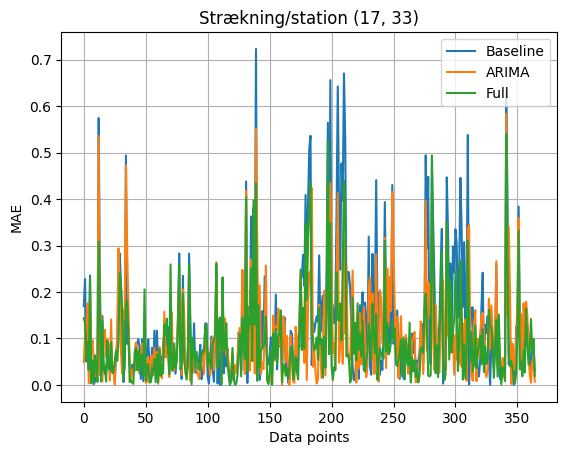

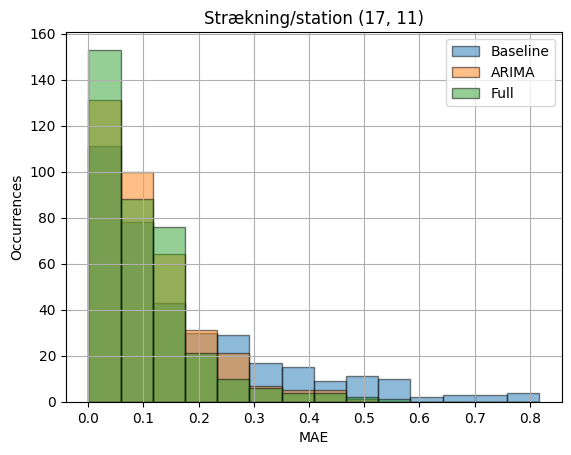

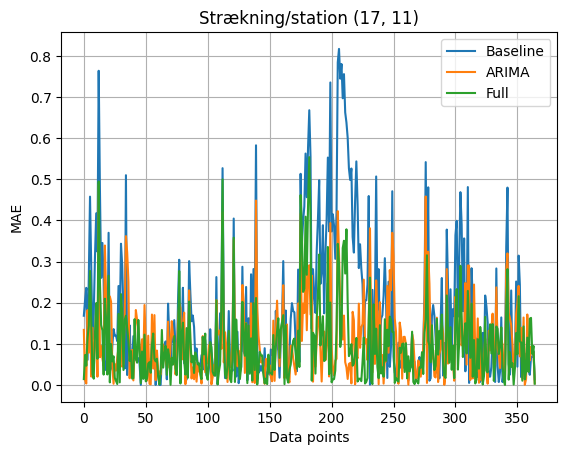

In [89]:
cv_function('Cleaned', 'SARIMA_Xgboost', 17)

# Predictions

In [80]:
def data_from_files_pred(relative_path):
    file_list_results = glob.glob(relative_path)
    index_start = len(relative_path.split('*')[0])

    strækning_station =[]
    y_true = []
    pred_full = []
    pred_arima = []
    pred_baseline = []

    for file in file_list_results:
        results_df = pd.read_csv(file)
        strækning_station += [file[index_start:].split('_')[0]]
        y_true += [results_df['y_true']]
        pred_full += [results_df['Predictions_full']]
        pred_arima += [results_df.get('Predictions_arima', [None])]
        pred_baseline += [results_df['Predictions_baseline']]
    if 'arima' in relative_path.lower():
        return pd.DataFrame(list(zip(strækning_station, y_true, pred_baseline, pred_arima, pred_full)), columns=['route_station', 'y_true', 'Predictions_baseline', 'Predictions_arima', 'Predictions_full'])
    else: 
        return pd.DataFrame(list(zip(strækning_station, y_true, pred_baseline, pred_full)), columns=['route_station', 'y_true', 'Predictions_baseline', 'Predictions_full'])

In [81]:
def plot_preds(filtered_df, initial_start, arima=False):
    initial_start = initial_start
    for row_no, row in filtered_df.iterrows():
        y_test = row['y_true']
        # Extract corresponding predictions from predictions DataFrame
        predictions_arima = row.get('Predictions_arima', [None])
        predictions_full = row['Predictions_full']
        # Dates: 
        x_dates = predictions_full.index
        route_station = row['route_station']
        plt.plot(x_dates[-initial_start:], y_test[-initial_start:], color='#33a02c', label='Test Data')
        if arima:
            predictions_arima = row.get('Predictions_arima', [None])
            plt.plot(x_dates[-initial_start:], predictions_arima[-initial_start:], color='#1E77B4', marker='x', label='ARIMA Predictions')
        plt.plot(x_dates[-initial_start:], predictions_full[-initial_start:], color='#FD7E0E', marker='x', label='Full Predictions')
        plt.title(f'Route/station {route_station}: Predictions & True Value')
        plt.xlabel('Observations')
        plt.ylabel('Train punctuality')
        plt.xticks(x_dates[-initial_start::10], rotation=45)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

In [82]:
def pred_function(dataset_name, model_name, specific_train_route, initial_start, use_arima):
    pred = data_from_files_pred(f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv')#['Errors_baseline'][0]
    pred_scores_specific_route = extract_train_routes(specific_train_route, pred)
    plot_preds(pred_scores_specific_route, initial_start, arima=use_arima)

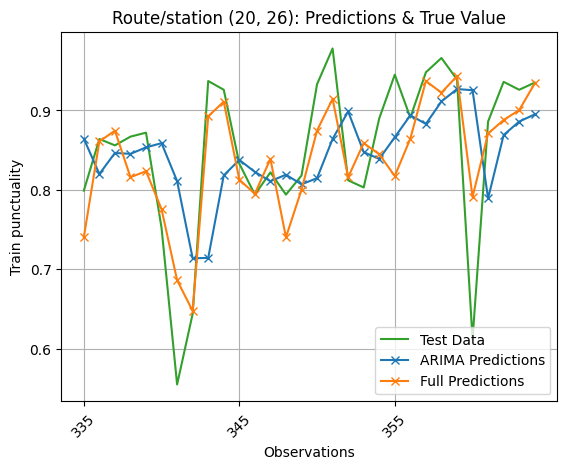

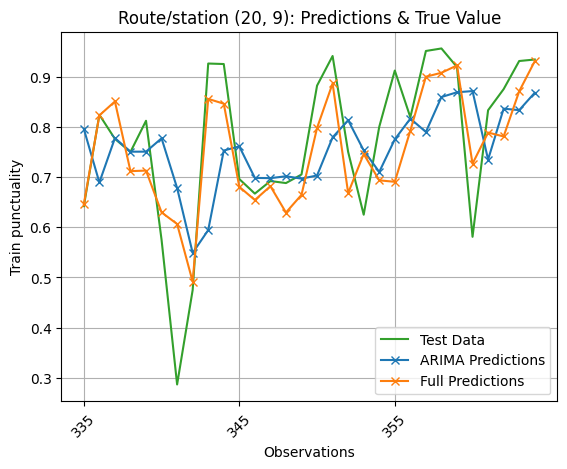

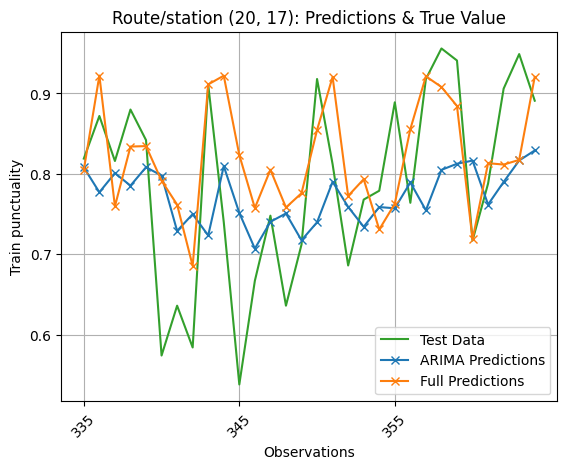

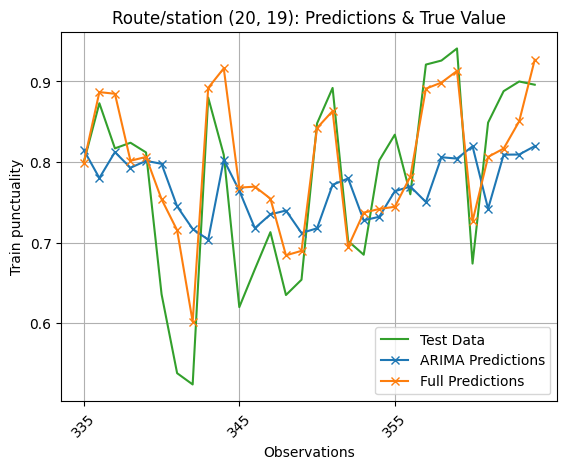

In [83]:
pred_function('Cleaned', 'SARIMA_Xgboost', 20, 30, use_arima=True)

In [10]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]
			return overall_pred, test, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros(prediction_blocks[0][3].shape)
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances += feature_importance
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		from collections import defaultdict
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros(prediction_blocks[0][4].shape)
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances += feature_importance
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'Predictions_ARIMA{i}'] = arima_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
				fold_dict[f'CV_score_ARIMA{i}'] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]
			result_df[f'Error_ARIMA{i}'] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	model_name = 'Xgboost'
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	print(f'Running... \nBoth ARIMA and Boosted Random Forest: {both} \nBoosted Random Forest Model: {model_name} \nDataset: {data_name}\nNo. predictions: {no_preds}')
	print('----------------')
	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds

	if both:
		model_name = 'ARIMA_' + model_name
		model_params_arima = pd.read_csv('Data/Best_model_parameters_ARIMA_route_station.csv')
		best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
		# Define models
		arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
		result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
		
	else:
		result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
	
	result_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=sys.argv[6])
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=365, data_name='Cleaned_simple_lagged', both=True, horizon=1)

Running... 
Both ARIMA and Boosted Random Forest: True 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_simple_lagged
No. predictions: 365
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fold 11
Fold 12
Fold 13
Fold 14
Fold 15
Fold 16
Fold 17
Fold 18
Fold 19
Fold 20
Fold 21
Fold 22
Fold 23
Fold 24
Fold 25
Fold 26
Fold 27
Fold 28
Fold 29
Fold 30
Fold 31
Fold 32
Fold 33
Fold 34
Fold 35
Fold 36
Fold 37
Fold 38
Fold 39
Fold 40
Fold 41
Fold 42
Fold 43
Fold 44
Fold 45
Fold 46
Fold 47
Fold 48
Fold 49
Fold 50
Fold 51
Fold 52
Fold 53
Fold 54
Fold 55
Fold 56
Fold 57
Fold 58
Fold 59
Fold 60
Fold 61
Fold 62
Fold 63
Fold 64
Fold 65
Fold 66
Fold 67
Fold 68
Fold 69
Fold 70
Fold 71
Fold 72
Fold 73
Fold 74
Fold 75
Fold 76
Fold 77
Fold 78
Fold 79
Fold 80
Fold 81
Fold 82
Fold 83
Fold 84
Fold 85
Fold 86
Fold 87
Fold 88
Fold 89
Fold 90
Fold 91
Fold 92
Fold 93
Fold 94
Fold 95
Fold 96
Fold 97
Fold 98
Fold 99
Fold 100
Fold 1